In [ ]:
# torch with cuda
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

In [ ]:
from ultralytics import YOLO
import torch
import os

# Load a model
# model = YOLO("best.onnx")
yolo_model = YOLO("yolo11n.pt")

path = os.path.join(os.path.abspath("."),"License Plate Recognition.v6i.yolov11.zip")

# # Train the model
# train_results = model.train(
#     data=path,  # path to dataset YAML
#     epochs=100,  # number of training epochs
#     # workers=100,
#     # patience=20,
#     imgsz=640,  # training image size
#     device="cuda" if torch.cuda.is_available() else "cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )

# # Evaluate model performance on the validation set
# metrics = model.val()

# # Export the model to ONNX format
# path = model.export(format="onnx")  # return path to exported model

In [ ]:
import cv2
from matplotlib import pyplot as plt
from safe_video import NumberPlateRecognition

rec = NumberPlateRecognition()

def run(img):
    rec.analyze(img)

# Perform object detection on an image
img = cv2.imread("example.jpg")
run(img)
img = cv2.flip(img, 0)
run(img)
img = cv2.flip(img, 1)
run(img)
img = cv2.flip(img, 0)
run(img)

In [ ]:
import cv2
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
from ultralytics import YOLO

model_path = os.path.join(os.path.abspath("."),"models","first10ktrain","weights","best.onnx")
model = YOLO(model_path, task='detect')

def add_noise(bboxes, mean=0, std_dev=5):
    noise = np.random.normal(mean, std_dev, bboxes.shape)
    noisy_bboxes = bboxes + noise
    return noisy_bboxes

def extract_bboxes(results):
    #bounding boxes can be extracted like that:
    bboxes = results[0].boxes.xyxy.cpu().numpy()
    return bboxes
    #trying to add noise and add it on the picture (doesn't work yet)
    # noisy_bboxes = add_noise(bboxes)
    # results[0].boxes.xyxy = torch.tensor(noisy_bboxes, device=results[0].boxes.xyxy.device)

    return results

# Perform object detection on an image
img = cv2.imread("example.jpg")
results = model(img)

# print(extract_bboxes(results))
# print(results[0].boxes.cpu().numpy())
# print(results[0])
# results[0].show()

In [ ]:
from safe_video import NumberPlateRecognition
import cv2

rec = NumberPlateRecognition()
#img = cv2.imread("example.jpg")
img = cv2.imread("example.jpg")
img = img[:, :, ::-1]



analyzed_img = rec.analyze(img)
result = rec.blur_image(img, analyzed_img.boxes)



plt.imshow(img)
plt.show()
plt.imshow(result)
plt.show()
# original = Image.fromarray(img, 'RGB')
# result2 = Image.fromarray(result, 'RGB')

In [ ]:
#rec.result.show()



In [1]:
from ultralytics.engine.results import Boxes
import cv2
import os
import numpy as np
import torch
from matplotlib import pyplot as plt
from ultralytics import YOLO
from safe_video import NumberPlateRecognition
import cv2

rec = NumberPlateRecognition()
image = cv2.imread("example.jpg")
image = image[:, :, ::-1]

In [ ]:
#yolo_model = YOLO("yolo11n.pt")

car_class_id = 2 # maybe switch to searching algo to find car == 2 if the library changes the class id


def analyze2(image):
    result = yolo_model(image)[0]
    data: Boxes = result.boxes.cpu().numpy()
    return (data.xyxy,data.conf,data.cls,result.names)


car_boxes = yolo_model.predict(image, save = False)[0]
xyxy,conf,cls,names = analyze2(image)
car_boxes_coordinates = xyxy[cls == car_class_id]
car_boxes_conf = conf[cls == car_class_id]

number_of_cars = len(car_boxes_coordinates)
# TODO: Für effizienz später direkt richtig initialisieren
store_box = np.zeros((number_of_cars, 4))
store_conf = np.zeros((number_of_cars,))
current_index = 0

for i in range(number_of_cars):
    x1, y1, x2, y2 = map(int, car_boxes_coordinates[i])
    cropped_image = image[y1:y2, x1:x2]

    print("--------------------------------")
    plate_rec = rec.analyze(cropped_image)
    print(plate_rec.conf)
    plt.imshow(cropped_image)
    plt.show()
    print("--------------------------------")
    
    num_plates = len(plate_rec.boxes)
    if num_plates > 0:
        # transform back to original coordinates
        transformed_boxes =  np.array(plate_rec.boxes) + [x1, y1, x1, y1]
        transformed_conf = np.array(plate_rec.conf)
        
        store_box[current_index:current_index + num_plates] = transformed_boxes
        store_conf[current_index:current_index + num_plates] = transformed_conf
        current_index += num_plates

store_box = store_box[:current_index]
store_conf = store_conf[:current_index]


# filter alle boxen mit einer conf von x raus 
conf_threshold = 0.5
store_box = store_box[store_conf > conf_threshold]
store_conf = store_conf[store_conf > conf_threshold]


result = rec.blur_image(image, store_box)
plt.imshow(result)
plt.show()




0: 448x640 14 cars, 3 traffic lights, 11.0ms
Speed: 4.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 License_Plate, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 2 License_Plates, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 512x640 1 License_Plate, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 640x608 1 License_Plate, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)

0: 512x640 1 License_Plate, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)

0: 608x640 2 License_Plates, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 License_Plate, 13.0ms
Speed: 2.0ms preproce

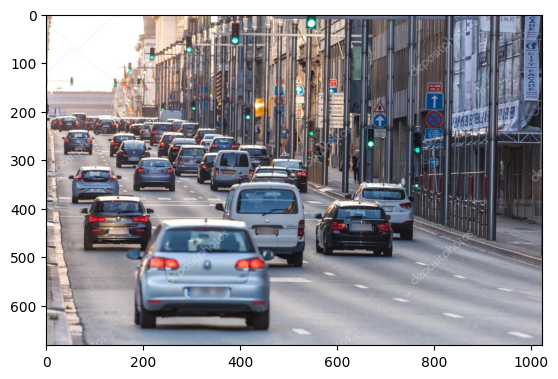

In [4]:
test = NumberPlateRecognition()
box, conf = test.detect_plate(image)
result = rec.blur_image(image, box)
plt.imshow(result)
plt.show()
